
# **Proyecto Integrador - Avance 4. Modelos alternativos**
## **Tecnologico de Monterrey**
------------------------------------------------------------------
### Profa. Dra. Grettel Barceló Alonso

### Prof. Dr. Luis Eduardo Falcón Morales

### Profa. Verónica Sandra Guzmán de Valle
------------------------------------------------------------------
### Marcela Alejandra Rosales Jiménez - A01032022
### José Antonio Mendoza Castro - A01794067



## **1. Preparación de ambiente**

### Instalacion de librerias

In [1]:
! pip install ipython
! pip install -U get-video-properties
! pip install sentence-transformers --quiet

### Carpeta actual

In [2]:
import os
os.getcwd()

'/home/marcela/repos/mna_proyecto_integrador_equipo13'

### Librerias

En esta seccion se importan todas las librerias usadas en el notebook. Principalmente se usan librerías para el analisis de texto y video.

In [3]:
import numpy as np
import pandas as pd
import cv2
from IPython.display import HTML
import matplotlib.pyplot as plt
import datetime
import random
import re
import json
import io
import pathlib
from base64 import b64encode
from videoprops import get_video_properties

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import gensim.downloader as api

from sentence_transformers import SentenceTransformer

/home/marcela/repos/mna_proyecto_integrador_equipo13/venv/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## **2. Recoleccion de datos de la nube**

En esta seccion se realiza una lectura de archivos de un bucket en Cloud Storage de un proyecto en Google Cloud Platform (GCP). La lectura se realiza usando una cuenta de servicio, los datos son almacenados en la carpeta '/content' de Colab.

In [13]:
from google.cloud import storage
from google.colab.patches import cv2_imshow

ModuleNotFoundError: No module named 'google'

### Cuenta de servicio

In [11]:
#Archivo .json de la cuenta de servcio
credentials = 'project-team-13-8b8c41c85749.json'

In [12]:
client = storage.Client.from_service_account_json(credentials)

NameError: name 'storage' is not defined

### Bucket

In [ ]:
#Nombre del bucket de Cloud Storage
bucket_name = 'bucket-video-wts'

In [ ]:
bucket = client.get_bucket(bucket_name)

### Lectura de datos

In [13]:
def make_folder(folder_name):
  """
  Funcion que crea una carpeta en el directorio actual.
  """
  folder_path = os.path.join('/content/', folder_name)
  os.makedirs(folder_path, exist_ok=True)

In [14]:
#Folder que se crea en la carpeta '/content' de Colab
folder_ds = 'dataset'

In [15]:
make_folder(folder_ds)

In [16]:
#Se crean las carpetas '/train', '/val' y '/annotations'
list_folder = ['dataset/train/', 'dataset/val/', 'dataset/annotations/']

In [17]:
for folder in list_folder:
  make_folder(folder)

In [18]:
list_path = ['train/', 'val/', 'annotations/']

In [19]:
#Se leen los archivos desde el bucket y se escriben en las carpetas correspondientes de Colab.
for path in list_path:
  blobs = [blob.name for blob in bucket.list_blobs(prefix=path)]
  df_blobs = pd.DataFrame(blobs, columns=['file'])
  df_blobs['check'] = df_blobs['file'].apply(lambda x: 1 if 'content' in x else 0)
  df_blobs['lenght'] = df_blobs['file'].apply(lambda x: len(x))
  for blob in blobs:
    if len(blob) < 24:
      pass
    else:
      blob_tmp = bucket.blob(blob)
      blob_tmp.download_to_filename('/content/dataset/' + path + blob.split('/')[-1])

## **3. Funciones**

En la presente seccion se definen todas las funciones utilizadas en el notebook. Funciones de lectura de archivos, de analisis de datos, de pre-procesamiento, feature engineering y modelado.

### Funciones de lectura de datos

In [4]:
def make_folder(folder_name):
  """
  Funcion que crea una carpeta en el directorio actual.
  """
  folder_path = os.path.join('/content/', folder_name)
  os.makedirs(folder_path, exist_ok=True)

In [5]:
def get_all_files(files_path):
  """
  Funcion que obtiene una lista de todos los archivos de un directorio.
  """
  files_path = pathlib.Path(files_path)
  listed_elements = list(files_path.rglob("*"))
  listed_files = [e for e in listed_elements if not e.is_dir()]

  return listed_files

In [6]:
def get_listed_files_with_types(listed_files):
  """
  Funcion que obtiene un diccionario con los tipos de archivos y la lista de archivos que pertenecen a ese tipo.
  """
  files_types = {}
  for ff in listed_files:
    ext = ff.suffix
    if not files_types.get(ext):
      files_types[ext] = []
    files_types[ext].append(str(ff))
  return files_types

### Funciones de analisis de datos

In [7]:
def get_cap_dataframe(overhead_view_list):
  """
  Funcion que obtiene un dataframe con la informacion de los videos.
  """
  overhead_view_num_frames = {}

  for ff in overhead_view_list:
      cap = cv2.VideoCapture(ff)
      overhead_view_num_frames[ff] = [int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FPS))]

  df_tmp = pd.DataFrame.from_dict(overhead_view_num_frames, orient='index', columns=['num_frames', 'frame_width', 'frame_height', 'fps'])
  df_tmp.reset_index(inplace=True)
  df_tmp.rename(columns={'index': 'video_path'}, inplace=True)

  return df_tmp

In [8]:
def get_radom_file(file_list):
  """
  Funcion que obtiene un archivo aleatorio de un directorio.
  """
  if file_list:
    return random.choice(file_list)
  else:
    return None

In [9]:
def play_video(video_path):

  """
  Funcion que ejecuta un video desde un folder.
  """

  video = open(video_path, 'rb').read()
  video_data_url = 'data:video/mp4;base64,' + b64encode(video).decode()

  print('Video Name: ', video_path)

  return HTML(f"""
  <video width="640" height="480" controls>
    <source src="{video_data_url}" type="video/mp4">
  </video>
  """)

In [10]:
def get_annotation_path(video_path):
  """
  Funcion que obtiene la ruta correspondiente de una anotacion.
  """
  annotation_path = re.search('.*T[0-9](?=_)', video_path).group(0).replace('train', 'annotations') + '_caption.json'
  return annotation_path

In [11]:
def get_annotation(video_path):
  """
  Funcion que obtiene la anotacion correspondiente de un video.
  """
  with open(get_annotation_path(video_path), 'r') as f:
    data = json.load(f)
  return data

In [12]:
def get_video_duration_in_seconds(video_path):
  """
  Funcion que devuelve la duracion en segundos de un video.
  """

  cap = cv2.VideoCapture(video_path)
  fps = cap.get(cv2.CAP_PROP_FPS)
  totalNoFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
  durationInSeconds = totalNoFrames // fps

  return 'Duration in seconds: ' +  str(durationInSeconds)

In [13]:
def get_video_characteristics(df_tmp):
  """
  Funcion que obtiene las caracteristicas generales de los videos.
  """

  general_characteristics = {}

  list_seconds = []
  list_width = []
  list_height = []
  list_frames = []
  list_fps = []

  for i, row in df_tmp.iterrows():
    width = row['frame_width']
    height = row['frame_height']
    frame = row['num_frames']
    fps = row['fps']
    durationInSeconds = row['num_frames'] / row['fps']
    list_width.append(width)
    list_height.append(height)
    list_frames.append(frame)
    list_fps.append(fps)
    list_seconds.append(durationInSeconds)

  general_characteristics['width_min'] = min(list_width)
  general_characteristics['width_mean'] = sum(list_width) / len(list_width)
  general_characteristics['width_max'] = max(list_width)
  general_characteristics['height_min'] = min(list_height)
  general_characteristics['height_mean'] = sum(list_height) / len(list_height)
  general_characteristics['height_max'] = max(list_height)
  general_characteristics['frames_min'] = min(list_frames)
  general_characteristics['frames_mean'] = sum(list_frames) / len(list_frames)
  general_characteristics['frames_max'] = max(list_frames)
  general_characteristics['fps_min'] = min(list_fps)
  general_characteristics['fps_mean'] = sum(list_fps) / len(list_fps)
  general_characteristics['fps_max'] = max(list_fps)
  general_characteristics['seconds_min'] = min(list_seconds)
  general_characteristics['seconds_mean'] = sum(list_seconds) / len(list_seconds)
  general_characteristics['seconds_max'] = max(list_seconds)

  return general_characteristics

In [14]:
def plot_video_characteristics(data):
  """
  Funcion que genera un grafico de barras con las caracteristicas de los videos.
  """
  variables = set([k.split('_')[0] for k in data.keys()])
  fig, axes = plt.subplots(len(variables), 1, figsize=(8, 6 * len(variables)))

  for i, var_name in enumerate(variables):
    ax = axes[i]
    min_val = data.get(f'{var_name}_min', None)
    mean_val = data.get(f'{var_name}_mean', None)
    max_val = data.get(f'{var_name}_max', None)

    if min_val is not None and mean_val is not None and max_val is not None:
      x_labels = ['Min', 'Mean', 'Max']
      values = [min_val, mean_val, max_val]

      ax.bar(x_labels, values, label=var_name)
      ax.set_ylabel('Value')
      ax.set_title(f"Min, Mean and Max of {var_name}")
      ax.legend()
  plt.tight_layout()
  plt.show()

### Funciones de pre-procesamiento

In [15]:
def get_preprocessing_of_annotation(text):
  """
  Funcion que obtiene el preprocesamiento de una anotacion.
  """
  #Minusculas
  text = text.lower()

  #Remover puntuacion
  text = re.sub(r'[^\w\s]', '', text)

  #Remover stop words
  stop_words = set(stopwords.words('english'))
  text = ' '.join([word for word in text.split() if word not in stop_words])

  #Lemantizacion
  lemmatizer = WordNetLemmatizer()
  text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

  return text

In [16]:
def write_annotation_preprocess(df_tmp):
  """
  Funcion que obtiene la anotacion preprocesada.
  """
  for i, row in df_tmp.iterrows():

    if 'caption' in row['annotation_path']:

      with open(row['annotation_path'], 'r') as input_file:
        data_tmp = json.load(input_file)

      for i, j in enumerate(data_tmp['event_phase']):
        data_tmp['event_phase'][i]['caption_pedestrian'] = get_preprocessing_of_annotation(data_tmp['event_phase'][i]['caption_pedestrian'])
        data_tmp['event_phase'][i]['caption_vehicle'] = get_preprocessing_of_annotation(data_tmp['event_phase'][i]['caption_vehicle'])

        with open(row['annotation_path'].replace('annotations', 'annotations_preprocess'), 'w') as output_file:
          json.dump(data_tmp, output_file)
    else:
      pass

In [17]:
def get_preprocessing_for_phase(folder_path, preprocessed_list, phase):
  for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
      filepath = os.path.join(folder_preprocess_path, filename)
      with open(filepath, 'r') as f:
        data = json.load(f)
        for item in data['event_phase']:
          if item['labels'][0] == str(phase):
            preprocessed_list.append(item['caption_pedestrian'])
  return preprocessed_list

### Funciones de feature engineer

In [18]:
def feature_matrix(annotation_tmp):
  """
  Funcion que realiza la ingenieria de caracteristicas.
  """
  vectorizer = TfidfVectorizer(max_features=5000)

  vectorizer.fit(annotation_tmp)

  feature_matrix = vectorizer.transform(annotation_tmp)

  #normalizer = Normalizer()

  #normalizer_matrix = normalizer.fit_transform(feature_matrix)

  return feature_matrix

In [19]:
def get_word_embedding(texts, wv):
  """
  Funcion que obtiene el embedding de un documento.
  """
  document_embeddings = []
  for text in texts:
    tokens = text.split()
    embeddings = [wv[token] for token in tokens if token in wv]
    if embeddings:
      document_embeddings.append(np.mean(embeddings, axis=0))
    else:
      document_embeddings.append(np.zeros(wv.vector_size))
  return np.array(document_embeddings)

In [20]:
def get_document_embedding(texts):
  """
  Funcion que genera los embeddings de los documentos.
  """
  model = SentenceTransformer('all-mpnet-base-v2')
  embeddings = model.encode(texts)
  return embeddings

## **4. Analisis de datos**

En esta seccion analizamos la base WTS, obtenemos de manera general las caracteristicas de los archivos utilizados durante el proyecto. Tambien obtenemos algunos datos de los archivos, como la duracion de los videos de donde son obtenidas las anotaciones.

In [47]:
dataset_path = f"/content/dataset"

### Cantidad y tipo de archivos a analizar

In [52]:
#Se obtienen todos los archivos
listed_files = get_all_files(f"{dataset_path}")
print(f"Cantidad de archivos en total = {len(listed_files)}")


files_by_ext = get_listed_files_with_types(listed_files)

for k, v in files_by_ext.items():
    print(f" - Extension {k} tiene {len(v)}")

NameError: name 'dataset_path' is not defined

### Cantidad de videos de entranamiento y validacion

In [49]:
#Se validan los archivos de entrenamiento y validacion
files_overhead_view = []
files_overhead_view_by_type = {
    'train': [],
    'val': [],
}

for mp4 in files_by_ext['.mp4']:
    if not f"{dataset_path}/external" in mp4 and not "vehicle_view" in  mp4:
        files_overhead_view.append(mp4)
        #omitir ruta videos al leer desde colab (videos/train)
        if "train" in mp4:
            files_overhead_view_by_type['train'].append(mp4)
        #omitir ruta videos al leer desde colab (videos/train)
        elif "val" in mp4:
            files_overhead_view_by_type['val'].append(mp4)
        else:
            print(f"W: No train ni val. Que es? {mp4}")


print(f"Cantidad de archivos a utilizar = {len(files_overhead_view)}")
for k, v in files_overhead_view_by_type.items():
    print(f" - {k} tiene {len(v)}")

Cantidad de archivos a utilizar = 600
 - train tiene 403
 - val tiene 197


In [50]:
#Generacion de un dataframe con las rutas de los archivos de entrenamiento
train_files_overhead_view = [f for f in  files_overhead_view if 'train' in f]

In [51]:
#Generacion de un dataframe con las rutas de los archivos de validacion
val_files_overhead_view = [f for f in  files_overhead_view if 'val' in f]

### Generacion de un pandas dataframe con las caracteristicas generales de los videos (frames number, width, height, fps) tanto para los videos entrenamiento como de validacion

In [52]:
df_train = get_cap_dataframe(train_files_overhead_view)

In [53]:
df_train.head()

,video_path,num_frames,frame_width,frame_height,fps
0,/content/dataset/train/20231006_34_CN24_T1_192...,2139,1920,1080,30
1,/content/dataset/train/20230929_71_SN18_T1_192...,2269,1920,1080,30
2,/content/dataset/train/20231006_30_CN10_T1_192...,2233,1920,1080,30
3,/content/dataset/train/20231006_35_SY3_T1_192....,2216,1920,1080,30
4,/content/dataset/train/20231013_114328_normal_...,1932,1920,1080,30


In [54]:
df_val = get_cap_dataframe(val_files_overhead_view)

In [55]:
df_val.head()

,video_path,num_frames,frame_width,frame_height,fps
0,/content/dataset/val/20230929_48_SN35_T1_192.1...,2182,1920,1080,30
1,/content/dataset/val/20230707_29_CN26_T1_Camer...,2173,1920,1080,30
2,/content/dataset/val/20230929_56_SY20_T1_192.1...,2138,1920,1080,30
3,/content/dataset/val/20231013_112853_normal_19...,1886,1920,1080,30
4,/content/dataset/val/20230929_16_CN34_T1_192.1...,2229,1920,1080,30


### Anotaciones de los videos de entrenamiento y validacion

In [65]:
annotations = []

for j in files_by_ext['.json']:
    annotations.append(j)

print(f"Cantidad de archivos a utilizar = {len(annotations)}")

TypeError: list indices must be integers or slices, not str

### Generacion de un pandas dataframe para la ruta de las anotaciones

In [57]:
df_annot = pd.DataFrame(annotations, columns=['annotation_path'])

In [58]:
df_annot.head()

,annotation_path
0,/content/dataset/annotations/20231006_23_CN2_T...
1,/content/dataset/annotations/20230922_24_CN31_...
2,/content/dataset/annotations/20230929_68_SN32_...
3,/content/dataset/annotations/20230922_48_SN47_...
4,/content/dataset/annotations/20230929_7_CN34_T...


### Ejecucion de un video aleatorio

In [59]:
video_path = get_radom_file(train_files_overhead_view)

In [ ]:
play_video(video_path)

### Obtencion de la anotacion del video

In [61]:
get_annotation(video_path)

{'vehicle_view': '20230728_37_CN38_T2_vehicle_view.mp4',
 'event_phase': [{'labels': ['4'],
   'caption_pedestrian': "The pedestrian is a person in their 20s, wearing a navy blue T-shirt and brown slacks. They have a height of 160 cm and are standing still. They are positioned on the left side of the vehicle, which is parked on a dry and level asphalt road. The pedestrian's body is perpendicular to the vehicle and they are facing the vehicle directly. Their line of sight is focused on the vehicle, and they are closely watching it. Despite being in close proximity to the vehicle, the pedestrian is unaware of its presence. The environment is bright and clear, with no obstructions or obstacles. Overall, the pedestrian seems to be calmly observing the vehicle while being unaware of any potential danger or the vehicle's presence.",
   'caption_vehicle': "The vehicle found itself positioned in front of a pedestrian. The distance between the vehicle and the pedestrian was close, prompting the

In [62]:
get_video_duration_in_seconds(video_path)

'Duration in seconds: 74.0'

In [63]:
props = get_video_properties(video_path)

In [64]:
props

{'index': 0,
 'codec_name': 'h264',
 'codec_long_name': 'H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10',
 'profile': 'High',
 'codec_type': 'video',
 'codec_tag_string': 'avc1',
 'codec_tag': '0x31637661',
 'width': 1920,
 'height': 1080,
 'coded_width': 1920,
 'coded_height': 1080,
 'closed_captions': 0,
 'has_b_frames': 2,
 'sample_aspect_ratio': '1:1',
 'display_aspect_ratio': '16:9',
 'pix_fmt': 'yuvj420p',
 'level': 40,
 'color_range': 'pc',
 'chroma_location': 'left',
 'refs': 1,
 'is_avc': 'true',
 'nal_length_size': '4',
 'r_frame_rate': '30/1',
 'avg_frame_rate': '30/1',
 'time_base': '1/15360',
 'start_pts': 0,
 'start_time': '0.000000',
 'duration_ts': 1139200,
 'duration': '74.166667',
 'bit_rate': '7142962',
 'bits_per_raw_sample': '8',
 'nb_frames': '2225',
 'disposition': {'default': 1,
  'dub': 0,
  'original': 0,
  'comment': 0,
  'lyrics': 0,
  'karaoke': 0,
  'forced': 0,
  'hearing_impaired': 0,
  'visual_impaired': 0,
  'clean_effects': 0,
  'attached_pic': 0,
  'timed

### Estadisticas para los datos de entrenamiento

In [65]:
df_train.head(3)

,video_path,num_frames,frame_width,frame_height,fps
0,/content/dataset/train/20231006_34_CN24_T1_192...,2139,1920,1080,30
1,/content/dataset/train/20230929_71_SN18_T1_192...,2269,1920,1080,30
2,/content/dataset/train/20231006_30_CN10_T1_192...,2233,1920,1080,30


In [66]:
get_video_characteristics(df_train)

{'width_min': 1920,
 'width_mean': 1920.0,
 'width_max': 1920,
 'height_min': 1080,
 'height_mean': 1080.0,
 'height_max': 1080,
 'frames_min': 1861,
 'frames_mean': 2239.2952853598017,
 'frames_max': 7735,
 'fps_min': 29,
 'fps_mean': 29.98759305210918,
 'fps_max': 30,
 'seconds_min': 62.03333333333333,
 'seconds_mean': 74.67660363366696,
 'seconds_max': 257.8333333333333}

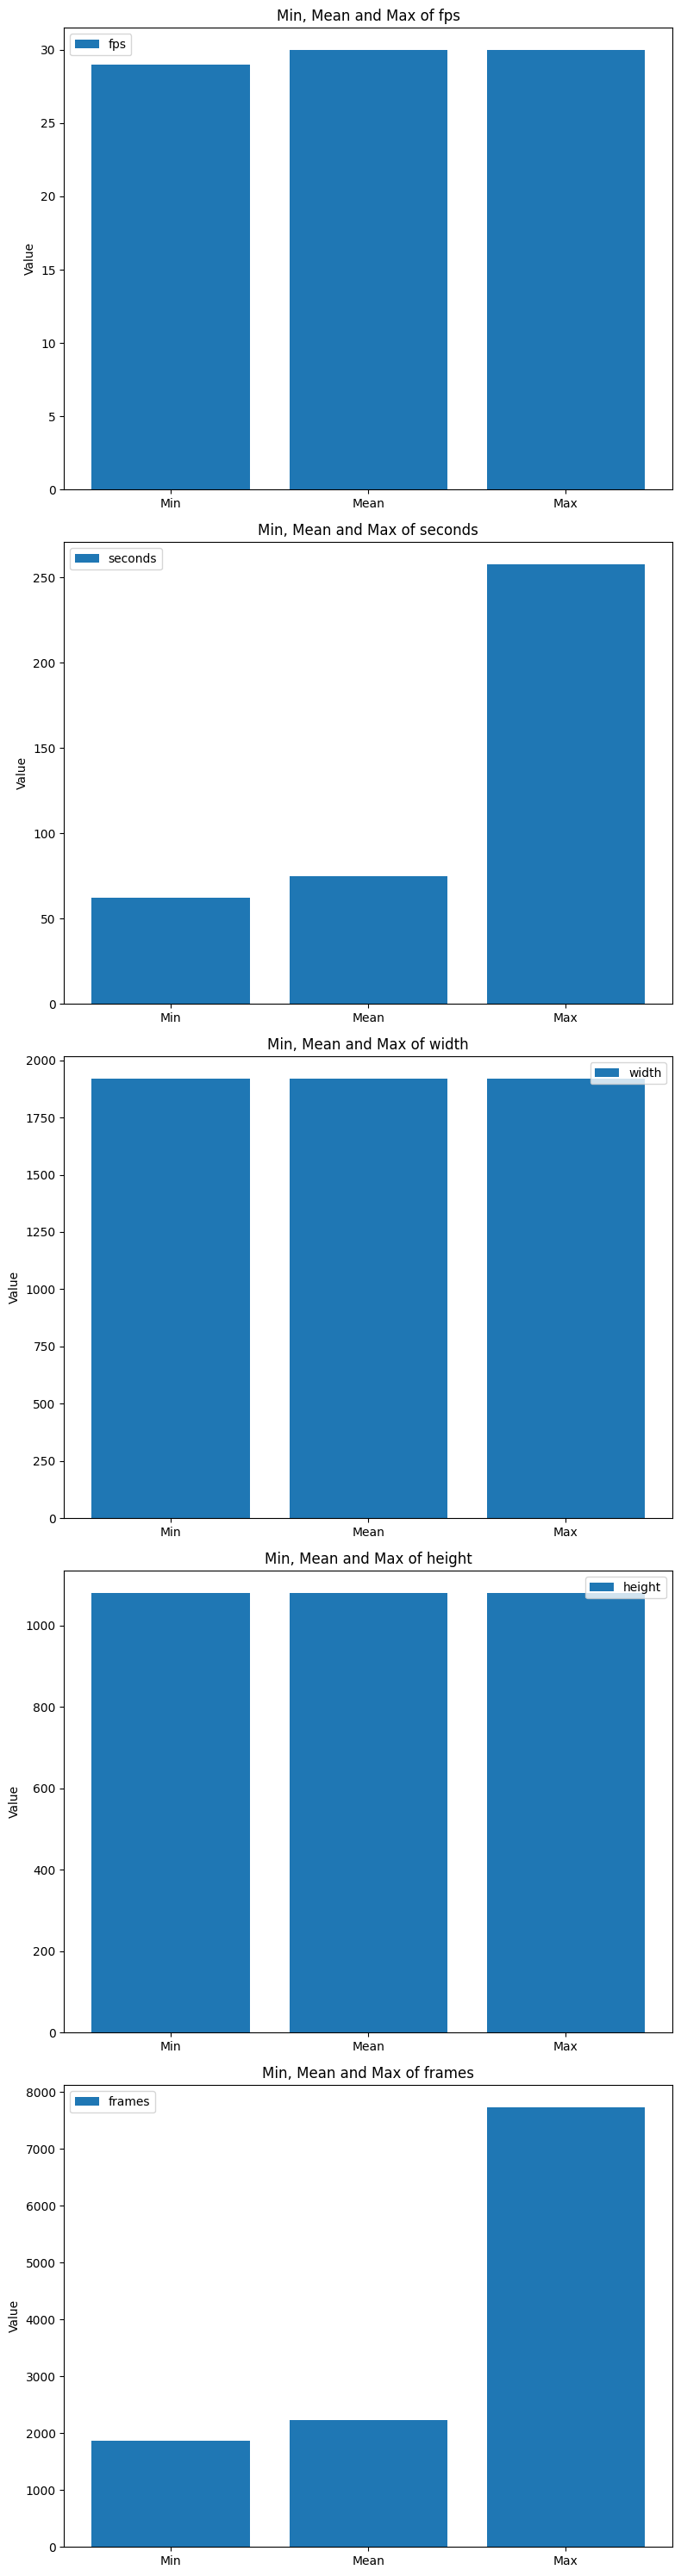

In [67]:
#Se generan estadisticas con las caracteristicas generales de los videos de entrenamiento (frames number, width, height, fps y seconds)
plot_video_characteristics(get_video_characteristics(df_train))

### Estadisticas para los datos de validacion

In [68]:
df_val.head(3)

,video_path,num_frames,frame_width,frame_height,fps
0,/content/dataset/val/20230929_48_SN35_T1_192.1...,2182,1920,1080,30
1,/content/dataset/val/20230707_29_CN26_T1_Camer...,2173,1920,1080,30
2,/content/dataset/val/20230929_56_SY20_T1_192.1...,2138,1920,1080,30


In [69]:
get_video_characteristics(df_val)

{'width_min': 1920,
 'width_mean': 1923.4111675126903,
 'width_max': 2592,
 'height_min': 1080,
 'height_mean': 1084.3857868020305,
 'height_max': 1944,
 'frames_min': 1873,
 'frames_mean': 2165.1522842639592,
 'frames_max': 2493,
 'fps_min': 30,
 'fps_mean': 30.0,
 'fps_max': 30,
 'seconds_min': 62.43333333333333,
 'seconds_mean': 72.17174280879864,
 'seconds_max': 83.1}

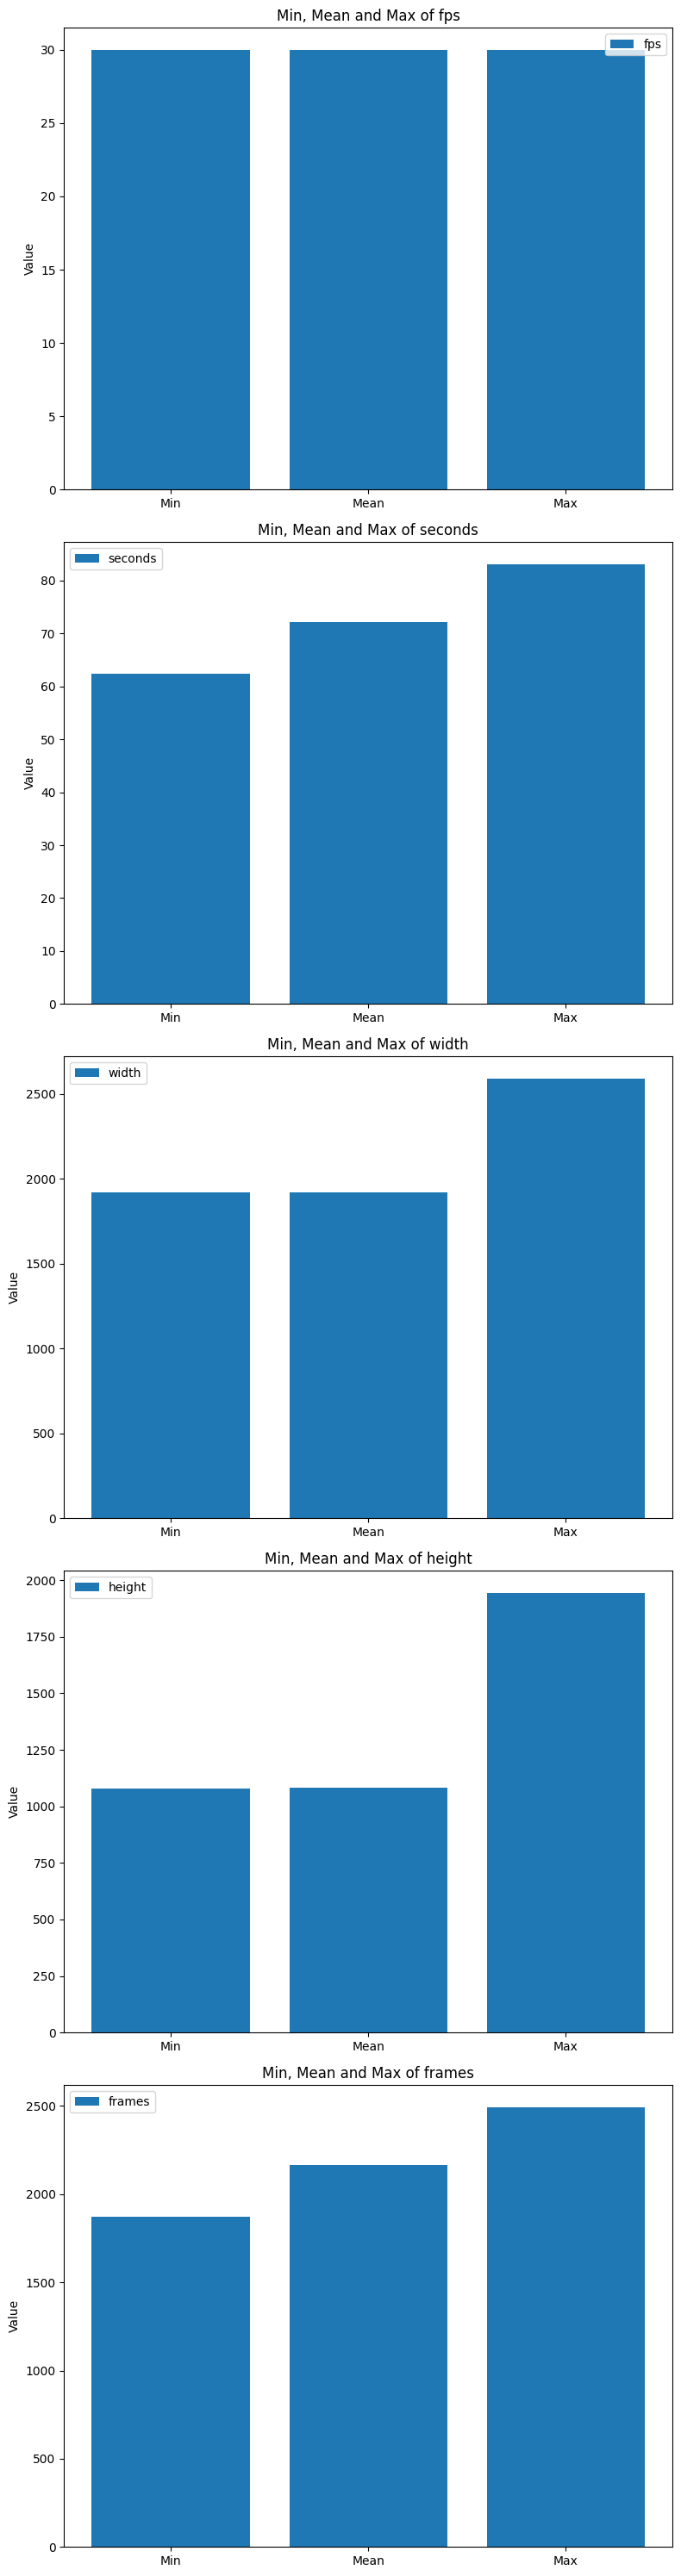

In [70]:
#Se generan estadisticas con las caracteristicas generales de los videos de entrenamiento (frames number, width, height, fps y seconds)
plot_video_characteristics(get_video_characteristics(df_val))

## **5. Ingenieria de caracteristicas**

Para esta seccion consideramos dos pasos importantes para el tratamiento de las anotaciones de los videos:



*   Preprocesamiento del texto
*   Tres tecnicas de feature engineering:

    - Feature Matrix
    - Word Embedding
    - Document Embedding

Para el primero consideramos normalizar el texto, conviertiendo todas las palabras a minusculas, eliminando las palabras mas comunes que no aportan un significado relevante al mismo y obteniendo las raices de las palabras a partir de la lemantizacion. Esto lo realizamos para mejorar nuestro insumo.

Para la Feature Matrix e utilizamos Term Frequency-Inverse Document Frequency (TF-IDF) para convertir las parablas a vectores y poder ocupar en una clusterizacion.

Para el Word Embedding construimos un Document Embedding a partir de la libreria gensim.


**Opcional:** Si cuentas con `annotations.zip` es posible correr la sección 5 después de la 1 y la 3 con la siguiente sección.

In [21]:
has_annotations_zip = True
if has_annotations_zip:
    ! mkdir -p dataset/annotations
    ! unzip -o -qq "annotations.zip" -d "dataset/annotations"
    ! rm -rf  dataset/annotations/.ipynb_checkpoints
    annotations = [ f"dataset/annotations/{filename}" for filename in os.listdir("dataset/annotations")]
    print(f"Numero de annotations: {len(annotations)}")
    
    df_annot = pd.DataFrame(annotations, columns=['annotation_path'])
    display(df_annot.head())

    # Se crea un nuevo folder para los datos pre-procesados
    folder_path = os.path.join('dataset/annotations_preprocess')
    os.makedirs(folder_path, exist_ok=True)
else:
    print(f"Debieron ejecutarse correctamente la sección 1, 2, 3 y 4 antes de avanzar.")
    # Se crea un nuevo folder para los datos pre-procesados
    make_folder('dataset/annotations_preprocess')

Numero de annotations: 944


,annotation_path
0,dataset/annotations/20230929_68_SN32_T1_192.16...
1,dataset/annotations/20231006_10_CY6_T1_192.168...
2,dataset/annotations/20230929_61_CN35_T1_captio...
3,dataset/annotations/20230728_25_SY22_T1_captio...
4,dataset/annotations/20230929_21_CY10_T1_192.16...


In [22]:
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
wv = api.load('word2vec-google-news-300')

### Se aplica el preprocesamiento y se escriben los archivos en el nuevo folder

In [23]:
write_annotation_preprocess(df_annot)

### Archivo sin procesamiento

In [24]:
get_annotation('dataset/annotations/20230707_12_SN17_T1_caption.json')

{'vehicle_view': '20230707_12_SN17_T1_vehicle_view.mp4',
 'event_phase': [{'labels': ['4'],
   'caption_pedestrian': 'The pedestrian, a male in his 30s approximately 170 cm tall, was wearing a black T-shirt and black slacks. It was a clear and bright day with dry road conditions on a residential road with two-way traffic. There were no sidewalks on both sides, and street lights were present. The pedestrian was positioned directly in front of a vehicle, facing the opposite direction. The pedestrian noticed the vehicle and was slowly moving in front of it. Suddenly, a collision occurred.',
   'caption_vehicle': 'The vehicle is positioned in front of a pedestrian, close in proximity. The vehicle has a clear field of view, as the pedestrian is visible. The vehicle is currently stopped and its speed is 0 km/h. The gender of the pedestrian is male, in his 30s with a height of 170 cm. He is wearing a black T-shirt on the upper body and black slacks on the lower body. The weather is clear and 

### Archivo con procesamiento

In [25]:
get_annotation('dataset/annotations_preprocess/20230707_12_SN17_T1_caption.json')

{'vehicle_view': '20230707_12_SN17_T1_vehicle_view.mp4',
 'event_phase': [{'labels': ['4'],
   'caption_pedestrian': 'pedestrian male 30 approximately 170 cm tall wearing black tshirt black slack clear bright day dry road condition residential road twoway traffic sidewalk side street light present pedestrian positioned directly front vehicle facing opposite direction pedestrian noticed vehicle slowly moving front suddenly collision occurred',
   'caption_vehicle': 'vehicle positioned front pedestrian close proximity vehicle clear field view pedestrian visible vehicle currently stopped speed 0 kmh gender pedestrian male 30 height 170 cm wearing black tshirt upper body black slack lower body weather clear brightness bright road surface condition dry road level asphalt traffic volume usual twoway residential road sidewalk side roadside strip street light present',
   'start_time': '9.476',
   'end_time': '14.017'},
  {'labels': ['3'],
   'caption_pedestrian': 'pedestrian male 30 stood per

In [26]:
folder_preprocess_path = 'dataset/annotations_preprocess/'

In [27]:
preprocessed_data_phase_0 = []
preprocessed_data_phase_1 = []
preprocessed_data_phase_2 = []
preprocessed_data_phase_3 = []
preprocessed_data_phase_4 = []

In [28]:
preprocessed_data_phase_0 = get_preprocessing_for_phase(folder_preprocess_path, preprocessed_data_phase_0, 0)
preprocessed_data_phase_1 = get_preprocessing_for_phase(folder_preprocess_path, preprocessed_data_phase_1, 1)
preprocessed_data_phase_2 = get_preprocessing_for_phase(folder_preprocess_path, preprocessed_data_phase_2, 2)
preprocessed_data_phase_3 = get_preprocessing_for_phase(folder_preprocess_path, preprocessed_data_phase_3, 3)
preprocessed_data_phase_4 = get_preprocessing_for_phase(folder_preprocess_path, preprocessed_data_phase_4, 4)

### Caso 1: Feature Matrix

In [29]:
feature_matrix0 = feature_matrix(preprocessed_data_phase_0)
feature_matrix1 = feature_matrix(preprocessed_data_phase_1)
feature_matrix2 = feature_matrix(preprocessed_data_phase_2)
feature_matrix3 = feature_matrix(preprocessed_data_phase_3)
feature_matrix4 = feature_matrix(preprocessed_data_phase_4)

### Caso 2: Word Embedding

In [30]:
word_embedding0 = get_word_embedding(preprocessed_data_phase_0, wv)
word_embedding1 = get_word_embedding(preprocessed_data_phase_1, wv)
word_embedding2 = get_word_embedding(preprocessed_data_phase_2, wv)
word_embedding3 = get_word_embedding(preprocessed_data_phase_3, wv)
word_embedding4 = get_word_embedding(preprocessed_data_phase_4, wv)

### Caso 3: Document embeddings

In [31]:
doc_embedding0 = get_document_embedding(preprocessed_data_phase_0)
doc_embedding1 = get_document_embedding(preprocessed_data_phase_1)
doc_embedding2 = get_document_embedding(preprocessed_data_phase_2)
doc_embedding3 = get_document_embedding(preprocessed_data_phase_3)
doc_embedding4 = get_document_embedding(preprocessed_data_phase_4)

## **Baseline**

In [32]:
def get_best_kmeans_model(feature_data_tmp, is_feature_matrix=True):
  """
  Funcion que obtiene el mejor modelo de kmeans.
  """

  dict_tmp = {'K: 2': [], 'K: 3': [], 'K: 4': [], 'K: 5': [], 'K: 6': [], 'K: 7': [], 'K: 8': [], 'K: 9': [], 'K: 10': [],}

  for k in range(2, 11):  # Check k values from 2 to 10
      kmeans = KMeans(n_clusters=k, random_state=0)
      cluster_assignments = kmeans.fit_predict(feature_data_tmp)
      silhouette = silhouette_score(feature_data_tmp, cluster_assignments)
      if is_feature_matrix:
        dbi = davies_bouldin_score(feature_data_tmp.toarray(), cluster_assignments)
      else:
        dbi = davies_bouldin_score(feature_data_tmp, cluster_assignments)

      dict_tmp['K: ' + str(k)].append(silhouette)
      dict_tmp['K: ' + str(k)].append(dbi)

  return dict_tmp

In [33]:
def get_df_from_dict(dict_tmp):
  """
  Funcion que obtiene un dataframe a partir de un diccionario.
  """
  data = []
  for k, v in dict_tmp.items():
    data.append([k, v[0], v[1]])
    df = pd.DataFrame(data, columns=['K', 'Silhouette', 'DBI'])
  return df

In [34]:
def kmeans_clustering(feature_matrix, num_clusters=5):
  """
  Funcion que realiza el kmeans clustering.
  """
  kmeans = KMeans(n_clusters=num_clusters, random_state=0)

  kmeans.fit(feature_matrix)

  cluster_assigments = kmeans.labels_

  return cluster_assigments

In [35]:
def get_best_dbscan_model(feature_data_tmp, eps_values, min_samples_values, is_feature_matrix=True):
  """
  Funcion que obtiene el mejor modelo de dbscan.
  """
  dict_tmp = {'eps': [], 'min_samples': [], 'silhouette_score': [], 'davies_score': []}

  for eps in eps_values:
    for min_samples in min_samples_values:
      dbscan = DBSCAN(eps=eps, min_samples=min_samples)
      cluster_assignments = dbscan.fit_predict(feature_data_tmp)

      if len(np.unique(cluster_assignments)) > 1:
        score = silhouette_score(feature_data_tmp, cluster_assignments)
        if is_feature_matrix:
          dbi = davies_bouldin_score(feature_data_tmp.toarray(), cluster_assignments)
        else:
          dbi = davies_bouldin_score(feature_data_tmp, cluster_assignments)
        dict_tmp['eps'].append(eps)
        dict_tmp['min_samples'].append(min_samples)
        dict_tmp['silhouette_score'].append(score)
        dict_tmp['davies_score'].append(dbi)

  return dict_tmp

In [36]:
def dbscan_clustering(feature_data_tmp, eps, min_samples):
  """
  Funcion que realiza el dbscan clustering.
  """
  dbscan = DBSCAN(eps=eps, min_samples=min_samples)

  cluster_assigments = dbscan.fit_predict(feature_data_tmp)

  return cluster_assigments

### **K-Means**

### K-Means con Feature Matrix

Fase: 0

In [37]:
dict_kmean_feature_matrix0 = get_best_kmeans_model(feature_matrix0)

In [38]:
get_df_from_dict(dict_kmean_feature_matrix0)

,K,Silhouette,DBI
0,K: 2,0.037844,4.453853
1,K: 3,0.038876,5.181844
2,K: 4,0.037384,4.617902
3,K: 5,0.033193,5.293273
4,K: 6,0.031834,4.965085
5,K: 7,0.031801,4.569899
6,K: 8,0.017806,4.498106
7,K: 9,0.014181,4.348871
8,K: 10,0.013775,4.367963


Fase: 1

In [39]:
dict_kmean_feature_matrix1 = get_best_kmeans_model(feature_matrix1)

In [40]:
get_df_from_dict(dict_kmean_feature_matrix1)

,K,Silhouette,DBI
0,K: 2,0.040217,4.294465
1,K: 3,0.034815,5.974185
2,K: 4,0.036086,5.171707
3,K: 5,0.029526,5.381209
4,K: 6,0.022262,5.309243
5,K: 7,0.012155,5.428734
6,K: 8,0.011980,4.936952
7,K: 9,0.008673,4.693511
8,K: 10,0.009085,4.545871


Fase: 2

In [41]:
dict_kmean_feature_matrix2 = get_best_kmeans_model(feature_matrix2)

In [42]:
get_df_from_dict(dict_kmean_feature_matrix2)

,K,Silhouette,DBI
0,K: 2,0.037494,4.322878
1,K: 3,0.041184,4.847852
2,K: 4,0.039329,4.455178
3,K: 5,0.028458,5.020156
4,K: 6,0.011374,5.785180
5,K: 7,0.010332,5.160856
6,K: 8,0.012276,4.831338
7,K: 9,0.010925,4.604476
8,K: 10,0.009653,4.371772


Fase: 3

In [43]:
dict_kmean_feature_matrix3 = get_best_kmeans_model(feature_matrix3)

In [44]:
get_df_from_dict(dict_kmean_feature_matrix3)

,K,Silhouette,DBI
0,K: 2,0.038136,4.324696
1,K: 3,0.041504,4.812271
2,K: 4,0.037728,4.841222
3,K: 5,0.038478,4.386083
4,K: 6,0.021791,4.711574
5,K: 7,0.018839,4.615600
6,K: 8,0.012716,4.589961
7,K: 9,0.014585,4.328838
8,K: 10,0.010515,4.478802


Fase: 4

In [45]:
dict_kmean_feature_matrix4 = get_best_kmeans_model(feature_matrix4)

In [46]:
get_df_from_dict(dict_kmean_feature_matrix4)

,K,Silhouette,DBI
0,K: 2,0.037089,4.391685
1,K: 3,0.036815,4.694278
2,K: 4,0.013041,5.619756
3,K: 5,0.019370,4.841486
4,K: 6,0.015084,4.857667
5,K: 7,0.007557,5.063114
6,K: 8,0.021979,4.577768
7,K: 9,0.012645,4.872911
8,K: 10,0.013363,4.595444


### K-Means con Word Embedding

Fase: 0

In [47]:
dict_kmean_wemb0 = get_best_kmeans_model(word_embedding0, False)

In [48]:
get_df_from_dict(dict_kmean_wemb0)

,K,Silhouette,DBI
0,K: 2,0.148926,2.720045
1,K: 3,0.075618,2.833889
2,K: 4,0.065870,3.089388
3,K: 5,0.068200,2.855899
4,K: 6,0.048539,3.155408
5,K: 7,0.047758,2.805419
6,K: 8,0.040348,3.070059
7,K: 9,0.043257,3.027779
8,K: 10,0.038561,3.096026


Fase: 1

In [49]:
dict_kmean_wemb1 = get_best_kmeans_model(word_embedding1, False)

In [50]:
get_df_from_dict(dict_kmean_wemb1)

,K,Silhouette,DBI
0,K: 2,0.073648,3.385999
1,K: 3,0.077317,2.776020
2,K: 4,0.032962,3.155379
3,K: 5,0.034026,3.631853
4,K: 6,0.030332,3.428930
5,K: 7,0.034632,3.096674
6,K: 8,0.041413,3.363355
7,K: 9,0.036036,3.074115
8,K: 10,0.028549,3.096434


Fase: 2

In [51]:
dict_kmean_wemb2 = get_best_kmeans_model(word_embedding2, False)

In [52]:
get_df_from_dict(dict_kmean_wemb2)

,K,Silhouette,DBI
0,K: 2,0.131377,2.725232
1,K: 3,0.063114,3.049087
2,K: 4,0.058600,3.341040
3,K: 5,0.037315,3.454641
4,K: 6,0.032678,3.531654
5,K: 7,0.037039,3.342303
6,K: 8,0.033565,3.330952
7,K: 9,0.027932,3.292805
8,K: 10,0.028880,3.340047


Fase: 3

In [53]:
dict_kmean_wemb3 = get_best_kmeans_model(word_embedding3, False)

In [54]:
get_df_from_dict(dict_kmean_wemb3)

,K,Silhouette,DBI
0,K: 2,0.130178,2.774464
1,K: 3,0.066282,2.982527
2,K: 4,0.056481,3.062187
3,K: 5,0.057209,2.886743
4,K: 6,0.062755,2.742056
5,K: 7,0.060048,2.706058
6,K: 8,0.042034,2.985488
7,K: 9,0.030822,3.109091
8,K: 10,0.029113,3.046008


Fase: 4

In [55]:
dict_kmean_wemb4 = get_best_kmeans_model(word_embedding4, False)

In [56]:
get_df_from_dict(dict_kmean_wemb4)

,K,Silhouette,DBI
0,K: 2,0.126671,2.809383
1,K: 3,0.070119,2.868514
2,K: 4,0.042560,3.061258
3,K: 5,0.044840,3.164363
4,K: 6,0.047026,3.117669
5,K: 7,0.047204,3.056516
6,K: 8,0.019787,3.488653
7,K: 9,0.027592,3.432503
8,K: 10,0.030184,3.377572


### K-Means con Document embeddings

Fase: 0

In [57]:
dict_kmean_doc_emb0 = get_best_kmeans_model(doc_embedding0, False)

In [58]:
get_df_from_dict(dict_kmean_doc_emb0)

,K,Silhouette,DBI
0,K: 2,0.072579,3.426163
1,K: 3,0.060776,3.320229
2,K: 4,0.051546,3.289497
3,K: 5,0.052355,3.009372
4,K: 6,0.044721,2.919961
5,K: 7,0.057848,2.801710
6,K: 8,0.054011,2.537279
7,K: 9,0.046961,2.607656
8,K: 10,0.054694,2.499687


Fase: 1

In [59]:
dict_kmean_doc_emb1 = get_best_kmeans_model(doc_embedding1, False)

In [60]:
get_df_from_dict(dict_kmean_doc_emb1)

,K,Silhouette,DBI
0,K: 2,0.063628,3.647453
1,K: 3,0.060705,3.354543
2,K: 4,0.043772,3.498533
3,K: 5,0.043199,3.351730
4,K: 6,0.045187,2.961921
5,K: 7,0.041451,3.260229
6,K: 8,0.052373,2.859496
7,K: 9,0.055024,2.737385
8,K: 10,0.062747,2.678373


Fase: 2

In [61]:
dict_kmean_doc_emb2 = get_best_kmeans_model(doc_embedding2, False)

In [62]:
get_df_from_dict(dict_kmean_doc_emb2)

,K,Silhouette,DBI
0,K: 2,0.050363,4.051848
1,K: 3,0.052042,3.573671
2,K: 4,0.052707,3.311448
3,K: 5,0.054003,3.171462
4,K: 6,0.063978,2.972276
5,K: 7,0.063601,2.825790
6,K: 8,0.053748,2.825072
7,K: 9,0.056479,2.771699
8,K: 10,0.056153,2.823772


Fase: 3

In [63]:
dict_kmean_doc_emb3 = get_best_kmeans_model(doc_embedding3, False)

In [64]:
get_df_from_dict(dict_kmean_doc_emb3)

,K,Silhouette,DBI
0,K: 2,0.053235,3.857137
1,K: 3,0.062491,3.345487
2,K: 4,0.051196,3.078655
3,K: 5,0.049139,3.191363
4,K: 6,0.044470,3.240530
5,K: 7,0.052457,3.133409
6,K: 8,0.050091,3.061735
7,K: 9,0.053085,2.734311
8,K: 10,0.052136,2.639845


Fase: 4

In [65]:
dict_kmean_doc_emb4 = get_best_kmeans_model(doc_embedding4, False)

In [66]:
get_df_from_dict(dict_kmean_doc_emb4)

,K,Silhouette,DBI
0,K: 2,0.155155,2.189548
1,K: 3,0.113171,2.979371
2,K: 4,0.060041,3.623912
3,K: 5,0.058713,3.411080
4,K: 6,0.047160,3.358336
5,K: 7,0.046300,3.078916
6,K: 8,0.041562,3.146894
7,K: 9,0.045522,3.194768
8,K: 10,0.045999,2.992510


### **DBSCAN**

In [67]:
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
min_samples_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

### DBSCAN con Feature Matrix

Fase: 0

In [68]:
dict_dbscan_feature_matrix0 = get_best_dbscan_model(feature_matrix0, eps_values, min_samples_values)

In [69]:
pd.DataFrame.from_dict(dict_dbscan_feature_matrix0)

,eps,min_samples,silhouette_score,davies_score
0,0.8,2,-0.070705,2.016717
1,0.8,3,-0.058880,2.286519
2,0.9,2,-0.064377,2.810909
3,0.9,3,-0.051834,3.805892
4,0.9,4,-0.054873,3.726429
5,0.9,5,-0.065586,3.224403
6,0.9,6,-0.070677,2.990285
7,1.0,2,-0.025007,4.957897
8,1.0,3,0.007882,8.022575
9,1.0,4,0.007574,7.891427


Fase: 1

In [70]:
dict_dbscan_feature_matrix1 = get_best_dbscan_model(feature_matrix1, eps_values, min_samples_values)

In [71]:
pd.DataFrame.from_dict(dict_dbscan_feature_matrix1)

,eps,min_samples,silhouette_score,davies_score
0,0.7,2,-0.036843,1.576209
1,0.8,2,-0.094089,1.831796
2,0.9,2,-0.067409,2.787524
3,0.9,3,-0.058845,3.213039
4,0.9,4,-0.048993,3.540410
5,0.9,5,-0.048993,3.540410
6,0.9,6,-0.060103,3.147212
7,0.9,7,-0.059765,3.261260
8,0.9,8,-0.046143,3.291545
9,1.0,2,-0.019885,4.917917


Fase: 2

In [72]:
dict_dbscan_feature_matrix2 = get_best_dbscan_model(feature_matrix2, eps_values, min_samples_values)

In [73]:
pd.DataFrame.from_dict(dict_dbscan_feature_matrix2)

,eps,min_samples,silhouette_score,davies_score
0,0.8,2,-0.082778,1.832904
1,0.9,2,-0.069405,2.764461
2,0.9,3,-0.067213,3.240895
3,0.9,4,-0.076351,2.930913
4,0.9,5,-0.057281,2.803225
5,0.9,6,-0.038638,2.982955
6,1.0,2,-0.008063,4.137582
7,1.0,3,0.007700,7.574755
8,1.0,4,0.004779,7.590070
9,1.0,5,0.004779,7.590070


Fase: 3

In [74]:
dict_dbscan_feature_matrix3 = get_best_dbscan_model(feature_matrix3, eps_values, min_samples_values)

In [75]:
pd.DataFrame.from_dict(dict_dbscan_feature_matrix3)

,eps,min_samples,silhouette_score,davies_score
0,0.8,2,-0.085819,1.922722
1,0.9,2,-0.065058,2.673912
2,0.9,3,-0.058562,3.467941
3,0.9,4,-0.070471,3.059208
4,0.9,5,-0.069218,2.901618
5,0.9,6,-0.045715,2.994356
6,1.0,2,-0.016839,4.260654
7,1.0,3,0.008152,7.880925
8,1.0,4,0.007869,7.864844
9,1.0,5,0.006406,7.747857


Fase: 4

In [76]:
dict_dbscan_feature_matrix4 = get_best_dbscan_model(feature_matrix4, eps_values, min_samples_values)

In [77]:
pd.DataFrame.from_dict(dict_dbscan_feature_matrix4)

,eps,min_samples,silhouette_score,davies_score
0,0.8,2,-0.027329,1.745414
1,0.9,2,-0.063897,2.424800
2,0.9,3,-0.030614,3.331986
3,0.9,4,-0.043515,2.792930
4,0.9,5,-0.048519,2.874142
5,1.0,2,-0.035141,3.260619
6,1.0,3,-0.003757,5.415993
7,1.0,4,-0.003768,5.386842
8,1.0,5,-0.012263,4.559541
9,1.0,6,-0.016719,4.306364


### DBSCAN con Word Embeding

Fase: 0

In [78]:
dict_dbscan_wemb0 = get_best_dbscan_model(word_embedding0, eps_values, min_samples_values, False)

In [79]:
pd.DataFrame.from_dict(dict_dbscan_wemb0)

,eps,min_samples,silhouette_score,davies_score
0,0.2,2,-0.161405,2.088405
1,0.2,3,-0.147915,2.634543
2,0.2,4,-0.125989,2.580767
3,0.2,5,-0.098720,2.727327
4,0.3,2,0.167209,3.881690
5,0.3,3,0.167209,3.881690
6,0.3,4,0.167209,3.881690
7,0.3,5,0.169312,3.640282
8,0.3,6,0.174099,3.107751
9,0.3,7,0.178056,2.837429


Fase: 1

In [80]:
dict_dbscan_wemb1 = get_best_dbscan_model(word_embedding1, eps_values, min_samples_values, False)

In [81]:
pd.DataFrame.from_dict(dict_dbscan_wemb1)

,eps,min_samples,silhouette_score,davies_score
0,0.2,2,-0.184384,2.310849
1,0.2,3,-0.165687,2.623124
2,0.2,4,-0.131645,2.941119
3,0.3,2,0.168189,2.721170
4,0.3,3,0.201672,3.109671
5,0.3,4,0.199245,3.007487
6,0.3,5,0.199245,3.007487
7,0.3,6,0.196363,3.068255
8,0.3,7,0.195607,2.945951
9,0.3,8,0.195607,2.945951


Fase: 2

In [82]:
dict_dbscan_wemb2 = get_best_dbscan_model(word_embedding2, eps_values, min_samples_values, False)

In [83]:
pd.DataFrame.from_dict(dict_dbscan_wemb2)

,eps,min_samples,silhouette_score,davies_score
0,0.2,2,-0.151295,2.205871
1,0.2,3,-0.092575,2.529141
2,0.2,4,-0.093507,2.384379
3,0.3,2,0.090701,2.487770
4,0.3,3,0.176722,3.134118
5,0.3,4,0.176722,3.134118
6,0.3,5,0.176893,3.078690
7,0.3,6,0.163494,2.628696
8,0.3,7,0.182484,2.856308
9,0.3,8,0.182484,2.856308


Fase: 3

In [84]:
dict_dbscan_wemb3 = get_best_dbscan_model(word_embedding3, eps_values, min_samples_values, False)

In [85]:
pd.DataFrame.from_dict(dict_dbscan_wemb3)

,eps,min_samples,silhouette_score,davies_score
0,0.2,2,-0.165009,2.193035
1,0.2,3,-0.150345,2.384165
2,0.2,4,-0.146619,2.507945
3,0.2,5,-0.097417,2.533737
4,0.3,2,0.192679,2.520124
5,0.3,3,0.217332,2.685253
6,0.3,4,0.215109,2.683896
7,0.3,5,0.215109,2.683896
8,0.3,6,0.215109,2.683896
9,0.3,7,0.215109,2.683896


Fase: 4

In [86]:
dict_dbscan_wemb4 = get_best_dbscan_model(word_embedding3, eps_values, min_samples_values, False)

In [87]:
pd.DataFrame.from_dict(dict_dbscan_wemb4)

,eps,min_samples,silhouette_score,davies_score
0,0.2,2,-0.165009,2.193035
1,0.2,3,-0.150345,2.384165
2,0.2,4,-0.146619,2.507945
3,0.2,5,-0.097417,2.533737
4,0.3,2,0.192679,2.520124
5,0.3,3,0.217332,2.685253
6,0.3,4,0.215109,2.683896
7,0.3,5,0.215109,2.683896
8,0.3,6,0.215109,2.683896
9,0.3,7,0.215109,2.683896


### DBSCAN con Document Embedding

Fase: 0

In [88]:
dict_dbscan_doc_emb0 = get_best_dbscan_model(doc_embedding0, eps_values, min_samples_values, False)

In [89]:
pd.DataFrame.from_dict(dict_dbscan_doc_emb0)

,eps,min_samples,silhouette_score,davies_score
0,0.3,2,-0.139900,2.545242
1,0.3,3,-0.106256,3.317991
2,0.3,4,-0.108994,3.103298
3,0.3,5,-0.110675,2.582380
4,0.4,2,0.057091,3.898945
5,0.4,3,0.090200,6.176473
6,0.4,4,0.089277,6.282564
7,0.4,5,0.089277,6.282564
8,0.4,6,0.089277,6.282564
9,0.4,7,0.086838,6.209416


Fase: 1

In [90]:
dict_dbscan_doc_emb1 = get_best_dbscan_model(doc_embedding1, eps_values, min_samples_values, False)

In [91]:
pd.DataFrame.from_dict(dict_dbscan_doc_emb1)

,eps,min_samples,silhouette_score,davies_score
0,0.3,2,-0.160009,2.072280
1,0.3,3,-0.104178,2.687401
2,0.3,4,-0.077200,2.955190
3,0.3,5,-0.087889,2.505694
4,0.3,6,-0.087889,2.505694
5,0.4,2,0.084024,6.589602
6,0.4,3,0.084024,6.589602
7,0.4,4,0.084024,6.589602
8,0.4,5,0.082587,6.367321
9,0.4,6,0.082587,6.367321


Fase: 2

In [92]:
dict_dbscan_doc_emb2 = get_best_dbscan_model(doc_embedding2, eps_values, min_samples_values, False)

In [93]:
pd.DataFrame.from_dict(dict_dbscan_doc_emb2)

,eps,min_samples,silhouette_score,davies_score
0,0.3,2,-0.156258,1.903745
1,0.3,3,-0.092393,2.001420
2,0.3,4,-0.092393,2.001420
3,0.4,2,0.075943,5.554902
4,0.4,3,0.082121,7.811590
5,0.4,4,0.081535,7.823158
6,0.4,5,0.077185,8.273249
7,0.4,6,0.075789,8.235342
8,0.4,7,0.075616,8.331627
9,0.4,8,0.072457,8.325866


Fase: 3

In [94]:
dict_dbscan_doc_emb3 = get_best_dbscan_model(doc_embedding3, eps_values, min_samples_values, False)

In [95]:
pd.DataFrame.from_dict(dict_dbscan_doc_emb3)

,eps,min_samples,silhouette_score,davies_score
0,0.3,2,-0.157694,2.155501
1,0.3,3,-0.132418,2.312786
2,0.3,4,-0.135686,2.577174
3,0.3,5,-0.110840,2.663945
4,0.3,6,-0.084805,2.797420
5,0.3,7,-0.087627,2.643431
6,0.3,8,-0.087627,2.643431
7,0.4,2,0.104265,5.686191
8,0.4,3,0.104265,5.686191
9,0.4,4,0.099213,6.022944


Fase: 4

In [96]:
dict_dbscan_doc_emb4 = get_best_dbscan_model(doc_embedding4, eps_values, min_samples_values, False)

In [97]:
pd.DataFrame.from_dict(dict_dbscan_doc_emb4)

,eps,min_samples,silhouette_score,davies_score
0,0.3,2,-0.198904,1.951949
1,0.3,3,-0.106309,2.201645
2,0.4,2,-0.049115,3.076860
3,0.4,3,-0.033310,3.281340
4,0.4,4,0.001972,4.366339
5,0.4,5,0.001603,5.256711
6,0.4,6,0.002781,5.171523
7,0.4,7,-0.007652,5.251504
8,0.4,8,0.036093,7.007095
9,0.4,9,0.035326,6.984198


### **Modelos de referencia elegidos**

Fase: 0

In [98]:
cluster_fase0 = dbscan_clustering(word_embedding0, 0.4, 2)

Fase: 1

In [99]:
cluster_fase0 = dbscan_clustering(word_embedding1, 0.4, 2)

Fase: 2

In [100]:
cluster_fase0 = dbscan_clustering(word_embedding2, 0.3, 7)

Fase: 3

In [101]:
cluster_fase0 = dbscan_clustering(word_embedding3, 0.4, 2)

Fase: 4

In [102]:
cluster_fase0 = dbscan_clustering(word_embedding4, 0.4, 2)

**¿Qué algoritmo (individual, NO ensambles) se puede utilizar como baseline para predecir las variables objetivo?**

DBSCAN

### **¿Se puede determinar la importancia de las características para el modelo generado? Recuerden que incluir características irrelevantes puede afectar negativamente el rendimiento del modelo y aumentar la complejidad sin beneficios sustanciales.**

No, estamos utilizando texto como input.

### **¿El modelo está sub/sobreajustando los datos de entrenamiento?**

No, no está sobreajustado.

### **¿Cuál es la métrica adecuada para este problema de negocio?**

Las metricas mas adecuadas son el Silhouette Score y el Davies Bouldin Score

### **¿Cuál debería ser el desempeño mínimo a obtener?**

Cerca de 0.3 en el Silhouette Score